In [ ]:
import re
import csv
import sys
import codecs
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from gensim.models import KeyedVectors

/Users/Shared/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### We first import necessary packages, we use gensim 4.0.0 and upgrade numpy to have a version that is greater than 1.16. We install tensorflow and keras as we need to use them quite heavily.

In [ ]:
from keras.models import Model
from keras.layers.merge import concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation


### we also import a lot keras packages. And our main LSTM is also included in keras.

In [ ]:

embeddingFilePath = '/Users/xilaizhang/Desktop/GoogleNews-vectors-negative300.bin'
trainFilePath = '/Users/xilaizhang/Downloads/quora-question-pairs/train.csv'
testFilePath = '/Users/xilaizhang/Downloads/quora-question-pairs/test.csv'
sequenceLength = 30
numberOfWords = 200000
embeddingDimension = 300
split = 0.1

lstmDimension = 200
denseDimension = 125
denseDropRate = 0.15 + np.random.rand() * 0.25
adjustWeight = True 


### https://radimrehurek.com/gensim/models/keyedvectors.html
### we will use gensim's load_word2vec_format fucntion to load the vectors from our input file, which is in the original Google’s word2vec C format. Each vector will have a dimension of 300.

In [ ]:
word2vec = KeyedVectors.load_word2vec_format(embeddingFilePath, binary=True)
print(len(word2vec.key_to_index))

3000000


### We will use the standard way to clean up the words. As the professor mentioned in lectures, we will clean up stopwords and etc. The code snippet to clean up the words can be widely found on the web, in this example, we will use the snippet as in https://medium.com/@gautam.karmakar/manhattan-lstm-model-for-text-similarity-2351f80d72f1.


In [ ]:

def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    text = text.lower().split()

    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    return(text)


### we will do processing on our input data. We will take the two questions as word lists, and they are at position 3 and poistion 4 after we choose the delimeter as comma. The label is at position 5, which tells whether or not the two questions are similar questions. After this step, we will have two arrays of question converted word lists that have been cleaned up by our previously defined function.

In [ ]:
questionSetOne = [] 
questionSetTwo = []
labels = []
with codecs.open(trainFilePath, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for line in reader:
        questionSetOne.append(text_to_wordlist(line[3]))
        questionSetTwo.append(text_to_wordlist(line[4]))
        labels.append(int(line[5]))


We check to see that there are 404290 raw questions

In [ ]:
print(len(questionSetOne))

404290


### In our test file, the first column is a test id that can be used to identify the test pairs. The second column and the third column are the questions. Similarly, we will convert the question (a sentence) into word list using our previously defined clean up function.

In [ ]:
testQuestionSetOne = []
testQuestionSetTwo = []

with codecs.open(testFilePath, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        testQuestionSetOne.append(text_to_wordlist(values[1]))
        testQuestionSetTwo.append(text_to_wordlist(values[2]))


In [ ]:
print(len(testQuestionSetOne))

2345796


### we use fit_on_texts to first create vocabulary index based on word frequency. For example,  a sentence like "The cat sat on the mat." will be converted to word_index["the"] = 1; word_index["cat"] = 2 . After we have this vocabulary created, we will use texts_to sequence to convert the words in a sentence into a sequence of integers. This sequence of integers are the corresponding integers from the dictionary (vocabulary) we just created. We can print out tokenizer.word_index to have a look. And not to our surprise, the most common word "the" is mapped to index 1. Index 0 is reserved for padding. The total length of word_index dictionary we created is 120499.

In [ ]:
tokenizer = Tokenizer(num_words=numberOfWords)
tokenizer.fit_on_texts(questionSetOne + questionSetTwo + testQuestionSetOne + testQuestionSetTwo)

sequenceOne = tokenizer.texts_to_sequences(questionSetOne)
sequenceTwo = tokenizer.texts_to_sequences(questionSetTwo)

word_index = tokenizer.word_index

In [ ]:
print(len(word_index))

120499


### We can now take a look at our converted word sequences. We will use pad_sequences to help us create our tensors. Without specifying a specific value, missing dimension entries will be padded with 0s. The total number of sequences we have is 404290.

In [ ]:
tensorOne = pad_sequences(sequenceOne, maxlen=sequenceLength)
tensorTwo = pad_sequences(sequenceTwo, maxlen=sequenceLength)
labels = np.array(labels)

In [ ]:
print(tensorOne.shape)
print(labels.shape)

(404290, 30)
(404290,)


### Now that we have the word_index dictionary(vocabulary) which contains our input word sequences from train file and test file, we are going to find how many of them also appeared in the google word2vec file. For those words that have also appeared in google word2vec file, we put them as an entry in the embedding matrix. The dimension of our embedding matrix is going to be determined by the number of words we have in the word_index dictionary, and also the embedding dimension we have specified earlier, which is 300.

In [ ]:
print('Preparing embedding matrix')

numWords = min(numberOfWords, len(word_index))+1

embeddingMatrix = np.zeros((numWords, embeddingDimension))
for word, i in word_index.items():
    if word in word2vec.key_to_index:
        embeddingMatrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embeddingMatrix, axis=1) == 0))


Preparing embedding matrix
ipykernel_launcher:8: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
Null word embeddings: 61789


### Afterwards, we split our previously processed data acquired from questions pairs, based on the indices after permutation.

In [ ]:
tensorDim = len(tensorOne)
permutation = np.random.permutation(tensorDim)
trainPart = permutation[:int(tensorDim*(1-split))]
valPart = permutation[int(tensorDim*(1-split)):]

partOneTrain = np.vstack((tensorOne[trainPart], tensorTwo[trainPart]))
partTwoTrain = np.vstack((tensorTwo[trainPart], tensorOne[trainPart]))
trainLabels = np.concatenate((labels[trainPart], labels[trainPart]))
partOneValidation = np.vstack((tensorOne[valPart], tensorTwo[valPart]))
partTwoValidation = np.vstack((tensorTwo[valPart], tensorOne[valPart]))
validationLabel = np.concatenate((labels[valPart], labels[valPart]))
validationWeight = np.ones(len(validationLabel))
if adjustWeight:
    validationWeight *= 0.472001959
    validationWeight[validationLabel==0] = 1.309028344


Now we specify the dimesions and create our embedding layers and lstm layers. The overall structure of our model looks like this 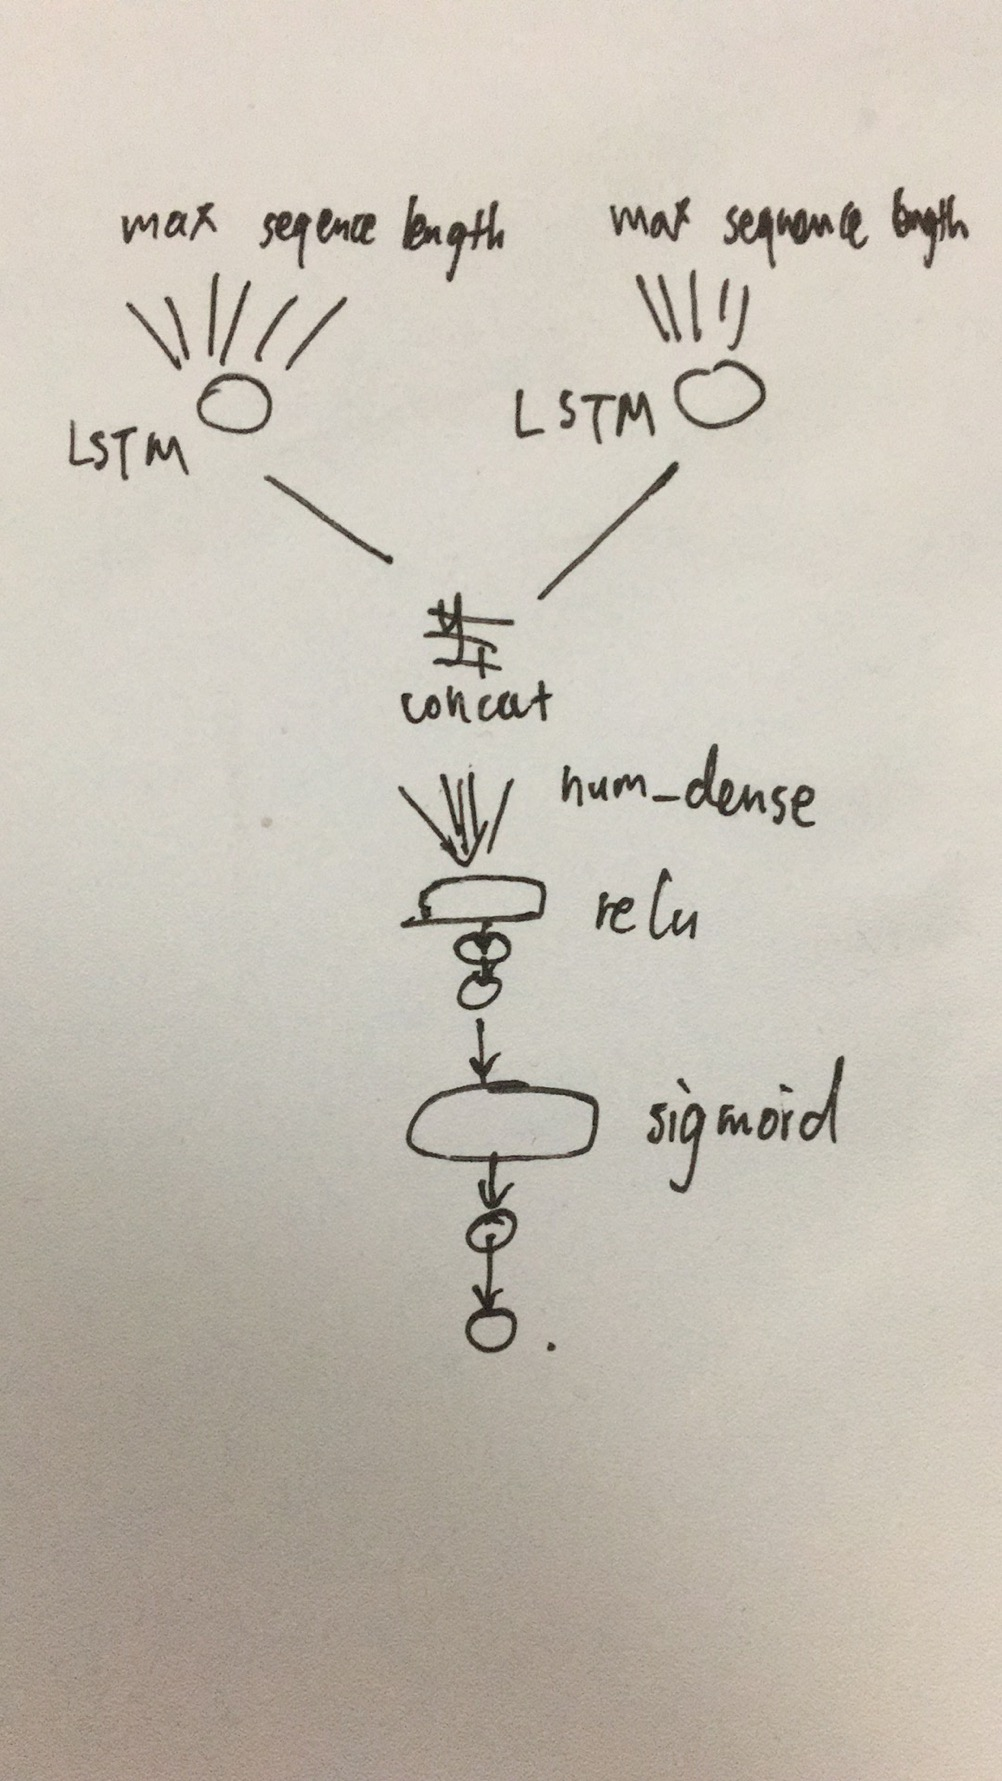





### In this project we used two parallel lstm lsyers, concatenated and passed through normal dropout and batch nomalization. Dropout will randomly set inputs to 0 to help avoid overfitting, and batch normalization will help us to maintain mean close to 0 and standard deviation close to 1. Afterwards we add a layer of relu, dropout and batch normalization, and then a final layer of sigmoid. 

In [ ]:
embedding_layer = Embedding(numWords, embeddingDimension, weights=[embeddingMatrix],
        input_length=sequenceLength, trainable=False)
lstmLayer = LSTM(lstmDimension, dropout=0.15 + np.random.rand() * 0.25, recurrent_dropout=0.15 + np.random.rand() * 0.25)

inputOne = Input(shape=(sequenceLength,), dtype='int32')
embedOne = embedding_layer(inputOne)
x1 = lstmLayer(embedOne)

inputTwo = Input(shape=(sequenceLength,), dtype='int32')
embedTwo = embedding_layer(inputTwo)
x2 = lstmLayer(embedTwo)

layer = concatenate([x1, x2])
layer = Dropout(denseDropRate)(layer)
layer = BatchNormalization()(layer)
layer = Dense(denseDimension, activation='relu')(layer)
layer = Dropout(denseDropRate)(layer)
layer = BatchNormalization()(layer)
result = Dense(1, activation='sigmoid')(layer)


### we would like to treat similar question pairs to have different weight then question pairs that are not similar. Therefore we define a weight dictionary to be passed into the model later.

In [ ]:
if adjustWeight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None

### we will supply the input and output to model for it to start training. For loss we will use the one learnt in class, namely, the cross entropy loss.

In [ ]:
model = Model(inputs=[inputOne, inputTwo], outputs=result)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])

### we will train with checkpoint. Model weights are saved at the end of every epoch, if it's the best seen so far. The model weights (that are considered the best) are loaded into the model. I don't have a GPU so I used a CPU, and each epoch run burns up about 80 percent of my macbook battery. So I run 2 epochs to make the accuracy higher than 70 percent.

In [ ]:
earlyStop =EarlyStopping(monitor='val_loss', patience=3)
savedFileName = 'lstm.h5'
modelCheckpoint = ModelCheckpoint(savedFileName, save_best_only=True, save_weights_only=True)

hist = model.fit([partOneTrain, partTwoTrain], trainLabels, validation_data=([partOneValidation, partTwoValidation], labels_val, validationWeight), epochs=2, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[earlyStop, modelCheckpoint])

model.load_weights(savedFileName)
bestLoass = min(hist.history['val_loss'])


356/356 [==============================] - 990s 3s/step - loss: 0.3731 - acc: 0.6931 - val_loss: 0.3488 - val_acc: 0.7053
